# Test the image subtraction step of the refactored Image Differencing
For this test, all steps after subtraction of the science image from the PSF-matched template were skipped
That means there was no:
* Decorrelation
* Varaince scaling
* DiaSource detection and measurement


In [1]:
from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
afwDisplay.setDefaultBackend('matplotlib') 
from lsst.pipe.tasks.scaleZeroPoint import ScaleZeroPointTask
task = ScaleZeroPointTask()

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [3]:
test_old_collection = 'u/sullivan/DM-33001_TestOldDiffim_G'
test_new_collection = 'u/sullivan/DM-33001_TestNewDiffim_B'

In [4]:
dataId ={'detector': 35, 'visit': 413635, 'skymap': 'hsc_rings_v1', 'instrument': 'DECam'}

In [5]:
def plot_image(exposure, label='Old', smooth=0):
    print(f"Median value of the image pixels: {np.nanmedian(exposure.image.array)}")
    try:
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        if smooth > 0:
            array = scipy.ndimage.median_filter(exposure.image.array, smooth)
            exposure = exposure.clone()
            exposure.image.array[...] = array
        afw_display.mtv(exposure.image)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.title(f"{label} image")
    except AssertionError:
        print(f"{label} image is entirely {np.nanmedian(exposure.image.array)}")
        
def plot_mask(exposure, label='Old', vmax=None):
    print(f"Median value of the mask pixels: {np.nanmedian(exposure.mask.array)}")
    try:
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        # afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        img = exposure.mask.array[...]
        if vmax is not None:
            img[img > vmax] = vmax
        plt.imshow(exposure.mask.array)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.colorbar()
        plt.title(f"{label} image")
    except AssertionError:
        print(f"{label} mask is entirely {np.nanmedian(exposure.mask.array)}")

def plot_variance(exposure, label='Old', smooth=0):
    print(f"Median value of the variance pixels: {np.nanmedian(exposure.variance.array)}")
    try:
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        if smooth > 0:
            array = scipy.ndimage.median_filter(exposure.variance.array, smooth)
            exposure = exposure.clone()
            exposure.variance.array[...] = array
        afw_display.mtv(exposure.variance)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.title(f"{label} variance")
    except AssertionError:
        print(f"{label} variance is entirely {np.nanmedian(exposure.image.array)}")

def plot_image_diff(exposure1, exposure2, label1='Old', label2='New', smooth=0, offset=0):
    print(f"Median value of the image difference pixels: {np.nanmedian(exposure1.image.array - exposure2.image.array)}")
    try:
        image_diff = exposure1.image.clone()
        
        if offset != 0:
            image_diff.array -= np.roll(exposure2.image.array, offset, (0, 1))
        else:
            image_diff -= exposure2.image
        
        if smooth > 0:
            array = scipy.ndimage.median_filter(image_diff.array, smooth)
            image_diff.array[...] = array
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        afw_display.mtv(image_diff)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.title(f"{label1} - {label2} image")
    except AssertionError:
        print(f"{label1} - {label2} image difference is entirely {np.nanmedian(exposure1.image.array - exposure2.image.array)}")

def plot_mask_diff(exposure1, exposure2, label1='Old', label2='New', smooth=0, offset=0):
    print(f"Median value of the mask difference pixels: {np.nanmedian(exposure1.mask.array - exposure2.mask.array)}")
    try:
        image_diff = exposure1.clone().mask.array[...]
        
        if offset != 0:
            image_diff -= np.roll(exposure2.mask.array, offset, (0, 1))
        else:
            image_diff -= exposure2.mask.array
        if np.std(image_diff) == 0:
            raise AssertionError
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        plt.imshow(image_diff)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.colorbar()      # turn off the x and y axes labels
        plt.title(f"{label1} - {label2} mask")
    except AssertionError:
        print(f"{label1} - {label2} mask difference is entirely {np.nanmedian(exposure1.mask.array - exposure2.mask.array)}")

def plot_variance_diff(exposure1, exposure2, label1='Old', label2='New', smooth=0):
    print(f"Median value of the variance difference pixels: {np.nanmedian(exposure1.variance.array - exposure2.variance.array)}")
    try:
        image_diff = exposure1.variance.clone()
        image_diff -= exposure2.variance
        if smooth > 0:
            array = scipy.ndimage.median_filter(image_diff.array, smooth)
            image_diff.array[...] = array
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        afw_display.mtv(image_diff)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.title(f"{label1} - {label2} variance")
    except AssertionError:
        print(f"{label1} - {label2} variance difference is entirely {np.nanmedian(exposure1.variance.array - exposure2.variance.array)}")

# Begin by looking at the warped templates.
These should be exactly the same

In [6]:
template_old_test =  butler.get('goodSeeingDiff_templateExp' , dataId=dataId, collections=test_old_collection)

In [7]:
template_new_test =  butler.get('goodSeeingDiff_templateExp' , dataId=dataId, collections=test_new_collection)

### Variance

Median value of the variance pixels: 0.11161437630653381


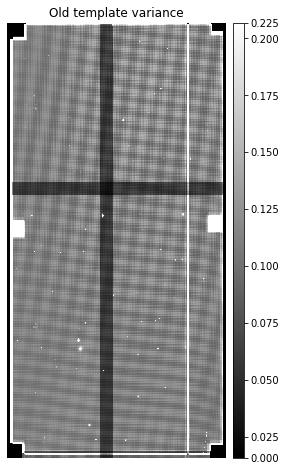

In [8]:
plot_variance(template_old_test, label='Old template')

Median value of the variance pixels: 0.11161437630653381


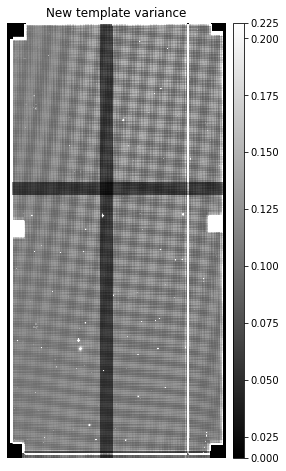

In [9]:
plot_variance(template_new_test, label='New template')

In [10]:
plot_variance_diff(template_old_test, template_new_test, label1='Old template', label2='New template')

Median value of the variance difference pixels: 0.0
Old template - New template variance difference is entirely 0.0


<Figure size 720x576 with 0 Axes>

### Image

Median value of the image pixels: 0.005162719637155533


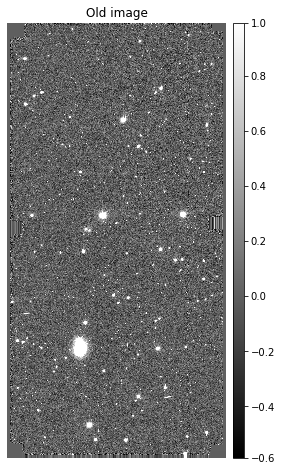

In [11]:
plot_image(template_old_test, label='Old')

Median value of the image pixels: 0.005162719637155533


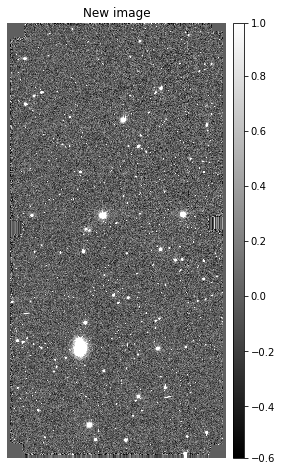

In [12]:
plot_image(template_new_test, label='New')

In [13]:
plot_image_diff(template_old_test, template_new_test, label1='Old template', label2='New template')

Median value of the image difference pixels: 0.0
Old template - New template image difference is entirely 0.0


<Figure size 720x576 with 0 Axes>

### Mask

Median value of the mask pixels: 0.0


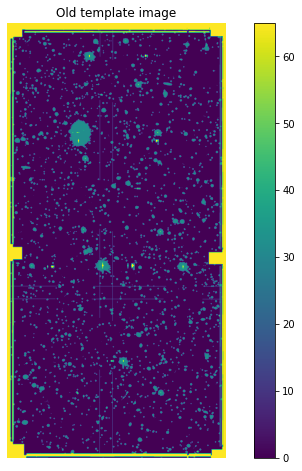

In [14]:
plot_mask(template_old_test, label='Old template', vmax=65)

Median value of the mask pixels: 0.0


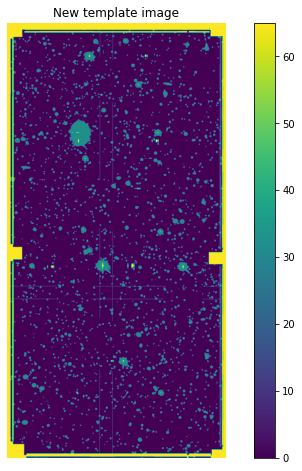

In [15]:
plot_mask(template_new_test, label='New template', vmax=65)

In [16]:
plot_mask_diff(template_old_test, template_new_test, label1='Old template', label2='New template')

Median value of the mask difference pixels: 0.0
Old template - New template mask difference is entirely 0.0


# Look at the PSF-matched templates

In [17]:
# Refresh the butler instance if you have a new run
butler = dafButler.Butler(repo)

In [18]:
matched_old_test =  butler.get('goodSeeingDiff_matchedExp' , dataId=dataId, collections=test_old_collection)
matched_new_test =  butler.get('goodSeeingDiff_matchedExp' , dataId=dataId, collections=test_new_collection)

### PSF-matched template variance

Median value of the variance pixels: 1.0451593399047852


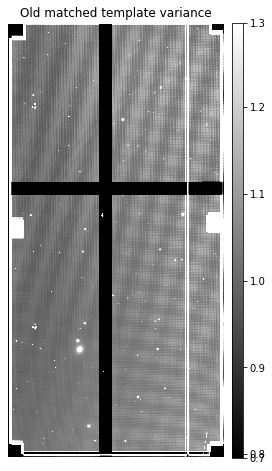

In [19]:
plot_variance(matched_old_test, label='Old matched template')

Median value of the variance pixels: 1.0451593399047852


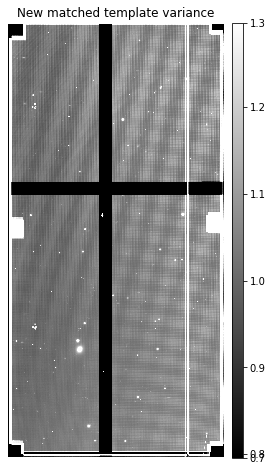

In [20]:
plot_variance(matched_new_test, label='New matched template')

In [21]:
plot_variance_diff(matched_old_test, matched_new_test, label1='Old matched', label2='New matched')

Median value of the variance difference pixels: 0.0
Old matched - New matched variance difference is entirely 0.0


/tmp/ipykernel_1734/2299231718.py:92: RuntimeWarning: invalid value encountered in subtract
  print(f"Median value of the variance difference pixels: {np.nanmedian(exposure1.variance.array - exposure2.variance.array)}")
/tmp/ipykernel_1734/2299231718.py:106: RuntimeWarning: invalid value encountered in subtract
  print(f"{label1} - {label2} variance difference is entirely {np.nanmedian(exposure1.variance.array - exposure2.variance.array)}")


<Figure size 720x576 with 0 Axes>

### PSF-matched template image

Median value of the image pixels: 0.011240316554903984


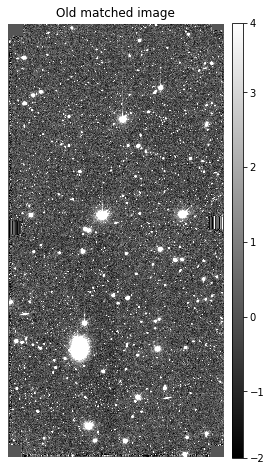

In [22]:
plot_image(matched_old_test, label='Old matched')

Median value of the image pixels: 0.011240316554903984


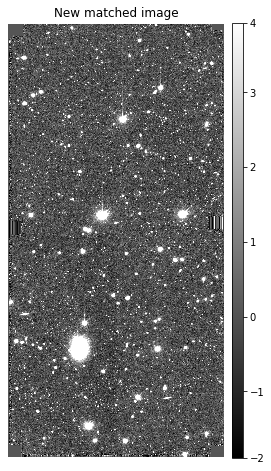

In [23]:
plot_image(matched_new_test, label='New matched')

In [24]:
plot_image_diff(matched_old_test, matched_new_test, label1='Old matched', label2='New matched', offset=0)

Median value of the image difference pixels: 0.0
Old matched - New matched image difference is entirely 0.0


<Figure size 720x576 with 0 Axes>

In [25]:
np.isnan(matched_old_test.image.array).sum()

122480

In [26]:
np.isnan(matched_new_test.image.array).sum()

122480

## Note on the NaNs in the image
We determined that the above Nan values were coming from a bug in the current image differencing, which we replicated in the new version for these tests.
The bug is that the template has a BBox slightly larger than the science image, so that it can be cropped after convolving by the matching kernel. However, the current code tests whether the pixels in the corners of the template have identical sky coordinates, and warps and crops the template if not. This means there is an additional (unnecessary) warping, and that the template is not actually larger than the science image. So, when it is convolved the NaNs at the edge can't be trimmed.

### PSF-matched template mask

Median value of the mask pixels: 0.0


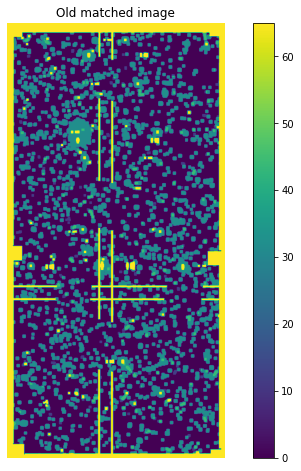

In [27]:
plot_mask(matched_old_test, label='Old matched', vmax=65)

Median value of the mask pixels: 0.0


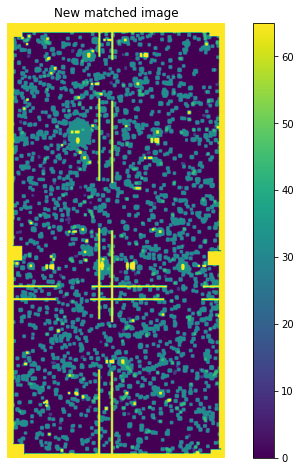

In [28]:
plot_mask(matched_new_test, label='New matched', vmax=65)

In [29]:
plot_mask_diff(matched_old_test, matched_new_test, label1='Old matched', label2='New matched')

Median value of the mask difference pixels: 0.0
Old matched - New matched mask difference is entirely 0.0


# Now look at the image differences

In [30]:
# Refresh the butler instance if you have a new run
butler = dafButler.Butler(repo)

In [31]:
diffim_old_test =  butler.get('goodSeeingDiff_differenceExp' , dataId=dataId, collections=test_old_collection)
diffim_new_test =  butler.get('goodSeeingDiff_differenceExp' , dataId=dataId, collections=test_new_collection)

In [32]:
ref_check = butler.registry.findDataset('goodSeeingDiff_differenceExp' , dataId=dataId, collections=test_new_collection)

In [33]:
ref_check.run

'u/sullivan/DM-33001_TestNewDiffim_B/20220511T204704Z'

In [34]:
ref_check.run

'u/sullivan/DM-33001_TestNewDiffim_B/20220511T204704Z'

### Variance

Median value of the variance pixels: 170.97389221191406


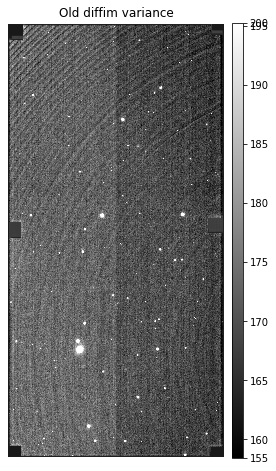

In [35]:
plot_variance(diffim_old_test, label='Old diffim')

Median value of the variance pixels: 170.97389221191406


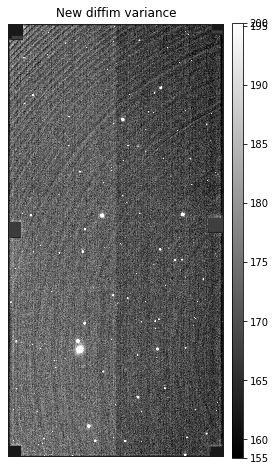

In [36]:
plot_variance(diffim_new_test, label='New diffim')

In [37]:
plot_variance_diff(diffim_old_test, diffim_new_test, label1='Old diffim', label2='New diffim')

Median value of the variance difference pixels: 0.0
Old diffim - New diffim variance difference is entirely 0.0


/tmp/ipykernel_1734/2299231718.py:92: RuntimeWarning: invalid value encountered in subtract
  print(f"Median value of the variance difference pixels: {np.nanmedian(exposure1.variance.array - exposure2.variance.array)}")
/tmp/ipykernel_1734/2299231718.py:106: RuntimeWarning: invalid value encountered in subtract
  print(f"{label1} - {label2} variance difference is entirely {np.nanmedian(exposure1.variance.array - exposure2.variance.array)}")


<Figure size 720x576 with 0 Axes>

### Image

Median value of the image pixels: 0.06798223406076431


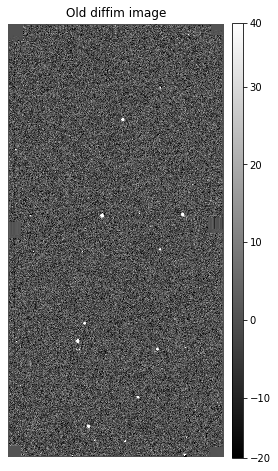

In [38]:
plot_image(diffim_old_test, label='Old diffim')

Median value of the image pixels: 0.06798221170902252


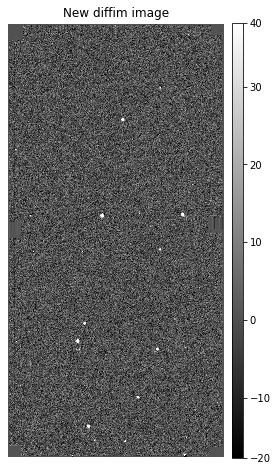

In [39]:
plot_image(diffim_new_test, label='New diffim')

Median value of the image difference pixels: 0.0


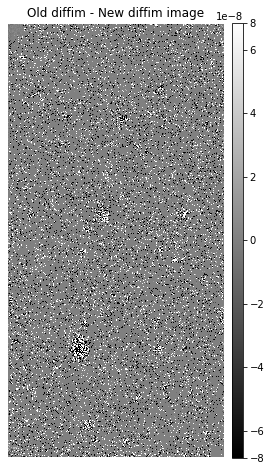

In [40]:
plot_image_diff(diffim_old_test, diffim_new_test, label1='Old diffim', label2='New diffim')

### Mask

Median value of the mask pixels: 0.0


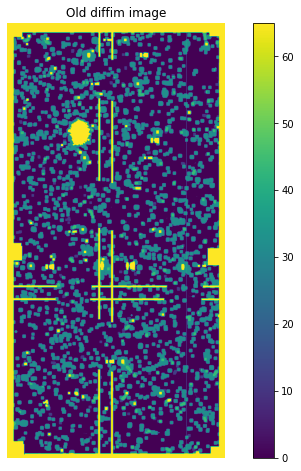

In [41]:
plot_mask(diffim_old_test, label='Old diffim', vmax=65)

Median value of the mask pixels: 0.0


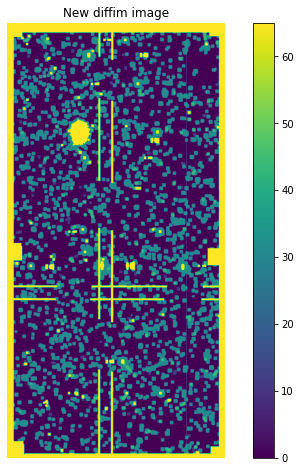

In [42]:
plot_mask(diffim_new_test, label='New diffim', vmax=65)

In [43]:
plot_mask_diff(diffim_old_test, diffim_new_test, label1='Old diffim', label2='New diffim')

Median value of the mask difference pixels: 0.0
Old diffim - New diffim mask difference is entirely 0.0


# Conclusion

The first stage of image differencing with the new pipeline looks good! The mask and variance are identically equal to the old pipeline, and the differences in the image plane of the image difference are small enough to be at machine precsion, and are not correlated.

Additional analysis with the rest of the image differencing pipeline will continue in a new notebook: DM-33001_Diffim-refactor-full-pipeline.ipynb